# Assignment 1 2AMM10 2023-2024

## Group: [35]
### Member 1: [Czaplicki, Michal]
### Member 2: [Dongen, Johan van]
### Member 3: [Mudragel, Dmytro]

# Data Preparation

## Data Loading

In [76]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

In [77]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [79]:
# function for loading the training data:

def load_data(file):
    """
    This function loads the data from the specified pickle file and returns a dictionary with the data
    :param filename: the pickle file
    :return: dict with data -- keys and values differ for the train data and test data for each task.
     Please see the cells with example code below for explanations and examples of the data structure per data set.
    """
    # path = '/content/drive/MyDrive/'
    with open(file, 'rb') as f:
        data_dict = pickle.load(f)
    return data_dict

In [80]:
file_path = "data_A1_2AMM10/"
train_data = load_data(file_path + 'train_data.pkl')

## Data Overview

In [81]:
def count_total_images(data):
    """
    Count the total number of images in the provided data.
    Parameters:
        data (dict): The dictionary containing the image data.
    Returns:
        int: The total number of images.
    """
    total_images = 0
    for alphabet in data.keys():
        for character in data[alphabet].keys():
            total_images += len(data[alphabet][character])
    return total_images

def display_image(data, alphabet_id, character_id, image_id):
    """
    Display a single image from the provided data.
    """
    alphabet = list(data.keys())[alphabet_id]
    character = list(data[alphabet].keys())[character_id]
    image = data[alphabet][character][image_id]
    plt.imshow(np.squeeze(image))
    plt.title(f"Alphabet: {alphabet}, Character: {character}, Image ID: {image_id}")
    plt.axis('off')
    plt.show()

def count_total_characters_per_alphabet(data):
    """
    Count the total number of unique characters in each alphabet of the provided data.
    Parameters:
        data (dict): The dictionary containing the image data.
    Returns:
        dict: A dictionary where keys are alphabets and values are the count of unique characters in each alphabet.
    """
    total_characters_per_alphabet = {}
    for alphabet in data.keys():
        total_characters_per_alphabet[alphabet] = len(data[alphabet].keys())
    return total_characters_per_alphabet

In [82]:

total_characters_per_alphabet = count_total_characters_per_alphabet(train_data)
for alphabet, count in total_characters_per_alphabet.items():
    print(f"Alphabet: {alphabet}, Total unique characters: {count}")


total_unique_characters = sum(total_characters_per_alphabet.values())
print(f"Total number of unique characters across all alphabets: {total_unique_characters}")

total_images = count_total_images(train_data)
print(f"Total number of images: {total_images}")


Alphabet: Alphabet_of_the_Magi, Total unique characters: 20
Alphabet: Anglo-Saxon_Futhorc, Total unique characters: 29
Alphabet: Arcadian, Total unique characters: 26
Alphabet: Armenian, Total unique characters: 41
Alphabet: Asomtavruli_(Georgian), Total unique characters: 40
Alphabet: Balinese, Total unique characters: 24
Alphabet: Bengali, Total unique characters: 46
Alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics), Total unique characters: 14
Alphabet: Braille, Total unique characters: 26
Alphabet: Burmese_(Myanmar), Total unique characters: 34
Alphabet: Cyrillic, Total unique characters: 33
Alphabet: Early_Aramaic, Total unique characters: 22
Alphabet: Futurama, Total unique characters: 26
Alphabet: Grantha, Total unique characters: 43
Alphabet: Greek, Total unique characters: 24
Alphabet: Gujarati, Total unique characters: 48
Alphabet: Hebrew, Total unique characters: 22
Alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics), Total unique characters: 16
Alphabet: Japanese_(hiragan

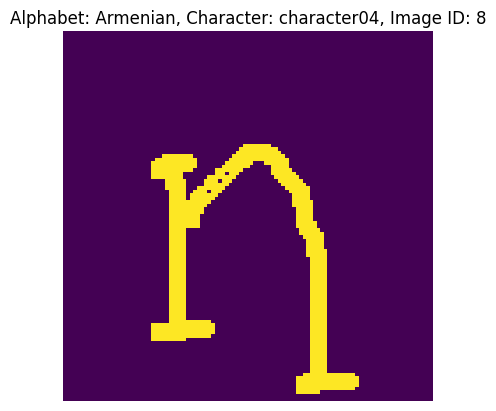

In [83]:
display_image(train_data, 3, 3, 8)

In [84]:
# the structure of the training data is a dict, where the keys are strings indicating the alphabet.
# The values are again dicts, with the keys being the character and the values being a list of images of that character.

# see the code below for examples of working with the train data

alphabets = list(train_data.keys())
print('example alphabet names:', alphabets[:5])
print('\n')
print('how to get an example image for a specific character:')

alphabet_id = 4
alphabet = alphabets[alphabet_id]  # a dict
characters_for_this_alphabet = list(train_data[alphabet].keys())
character_id = 5
character = characters_for_this_alphabet[character_id]
image_id = 2
print(f'shape of image {image_id} of character {character} of alphabet {alphabet}:', train_data[alphabet][character][image_id].shape)

example alphabet names: ['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)']


how to get an example image for a specific character:
shape of image 2 of character character06 of alphabet Asomtavruli_(Georgian): torch.Size([1, 105, 105])


In [85]:
# function for plotting some examples:

def plot_example_data(data_dict):
    """
    This function plots some examples of the data
    :param data_dict: dict with as keys a string specifying the alphabet, and as values a dict with as keys the character of the alphabet, and as values a list om images of the alphabet
    """
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    alphabets_to_plot = np.random.choice(list(data_dict.keys()), size=10, replace=False)

    for i, alphabet in enumerate(alphabets_to_plot):
        characters = data_dict[alphabet]
        character_to_plot = np.random.choice(list(characters.keys()), size=1)[0]
        images = characters[character_to_plot]
        im_idx = np.random.choice(len(images), size=1)[0]
        axs[i//5, i%5].imshow(images[im_idx].permute(1, 2, 0))
        axs[i//5, i%5].set_title(alphabet + '\n' + character_to_plot, fontsize=8)
        axs[i//5, i%5].axis('off')
    # plt.show()

<Figure size 640x480 with 0 Axes>

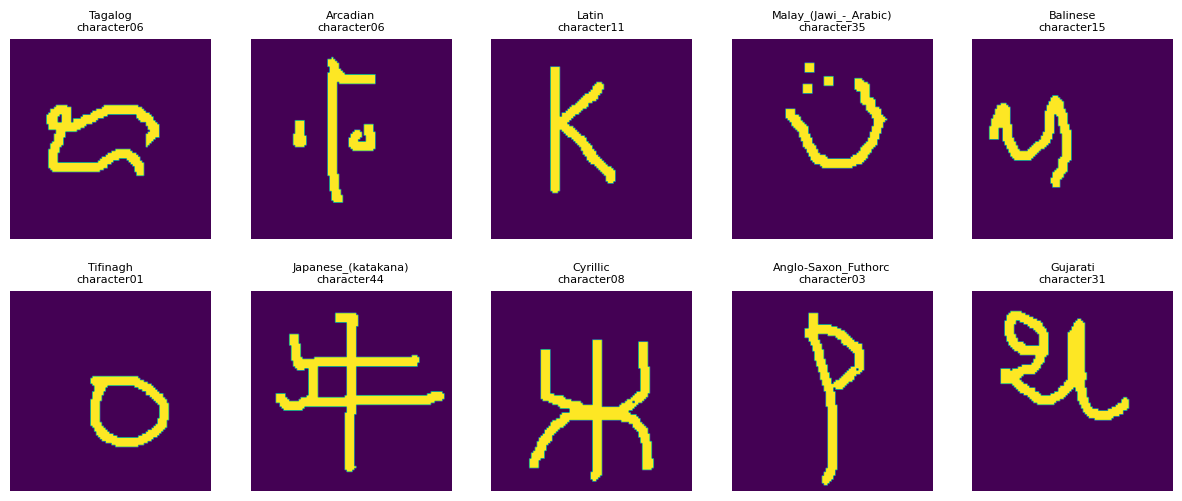

In [86]:
plt.figure()
plot_example_data(train_data)
# plt.savefig('example_data.png', dpi=600)
plt.show()

## Data Preparation

In [87]:
# Prepare dataset
def process_data(data, transform):
  alphabets = list(data.keys())
  x = []
  y = []
  alphabet_counts = []
  image_count_per_class = []
  count = 0
  for alphabet in alphabets:
    characters_for_this_alphabet = list(train_data[alphabet].keys())
    alphabet_counts.append(len(characters_for_this_alphabet))
    for character in characters_for_this_alphabet:
      image_count = 0
      for image in data[alphabet][character]:
        image_count +=1
        x.append(transform(image)) # Apply transformation to image (eg resizing, rotations)
        y.append(count)
      image_count_per_class.append(image_count)
      count += 1
  return x, y, alphabet_counts, image_count_per_class

In [88]:
def create_label_dict(labels):
  count = 0
  result = {}
  for label in labels:
    if label in result:
      continue
    result[label] = count
    result[count] = label # Bijective dict - Assuming label and count values dont overlap
    count += 1
  return result

def process_test_data(test_data, alphabet):
  x_train = []
  y_train = []
  labels = test_data['annotated_images_labels'][alphabet]
  label_dict = create_label_dict(labels)

  transform = T.Resize(32)
  for c in range(len(test_data['annotated_images'][alphabet])):

    x_train.append(transform(test_data['annotated_images'][alphabet][c]))
    y_train.append(label_dict[test_data['annotated_images_labels'][alphabet][c]])

  x_valid = []
  y_valid = []
  for c in range(len(test_data['unseen_images'][alphabet])):
    x_valid.append(transform(test_data['unseen_images'][alphabet][c]))
    y_valid.append(label_dict[test_data['unseen_images_labels'][alphabet][c]])
  return x_train, y_train, x_valid, y_valid, label_dict

In [89]:
from torch.utils.data.sampler import BatchSampler
import numpy as np
class BalancedBatchSampler(BatchSampler):
    """
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: np.where(  np.array(self.labels) == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

In [90]:
# Get the training data in the right format
resize = T.Resize(32)
transform_task1 = T.Compose([resize])
x_train, y_train, info, info2 = process_data(train_data, transform_task1)

In [91]:
from torch.utils.data import DataLoader, TensorDataset

train_batch_sampler = BalancedBatchSampler(y_train, n_classes=200, n_samples=10)
triplets_train_loader = torch.utils.data.DataLoader(TensorDataset( torch.stack(x_train), torch.stack([torch.tensor(x) for x in y_train]) ), batch_sampler=train_batch_sampler)

# Task 1: Character recognition

## Model Training

In [92]:
class TripletLoss(nn.Module):
    """
    Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """

    def __init__(self, margin, triplet_selector):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):

        triplets = self.triplet_selector.get_triplets(embeddings, target)

        if embeddings.is_cuda:
            triplets = triplets.cuda()


        anchor_idx= triplets[:, 0]
        positive_idx= triplets[:, 1]
        negative_idx= triplets[:, 2]

        ap_distances = (embeddings[anchor_idx] - embeddings[positive_idx]).pow(2).sum(1)  # .pow(.5)
        an_distances = (embeddings[anchor_idx] - embeddings[negative_idx]).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(ap_distances - an_distances + self.margin)

        return losses.mean()

In [93]:
from itertools import combinations

def pdist(vectors):
    distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(
        dim=1).view(-1, 1)
    return distance_matrix

class RandomTripletSelector():
    """
    Select random negative  example for  each positive pair  to create triplets
    """

    def __init__(self):
        super(RandomTripletSelector, self).__init__()

    def get_triplets(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        triplets = []
        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs

            # random choose one negative example for each positive pair
            temp_triplets = [[anchor_positive[0], anchor_positive[1], np.random.choice(negative_indices)] for anchor_positive in anchor_positives]
            triplets += temp_triplets

        return torch.LongTensor(np.array(triplets))
class Informative_Negative_TripletSelector():

    def __init__(self, margin):
        super(Informative_Negative_TripletSelector, self).__init__()

        self.margin = margin

   # Our goal is to mining informative triplets.
    def informative_negative(self, loss_values):

        informative_negative = np.where(loss_values > 0)[0]
        return np.random.choice(informative_negative) if len(informative_negative) > 0 else None


    def get_triplets(self, embeddings, labels):

        if torch.cuda.is_available()==False:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)
        distance_matrix = distance_matrix.cpu()

        labels = labels.cpu().data.numpy()
        triplets = []

        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs
            anchor_positives = np.array(anchor_positives)


            ap_distances = distance_matrix[anchor_positives[:, 0], anchor_positives[:, 1]]
            for anchor_positive, ap_distance in zip(anchor_positives, ap_distances):
                loss_values = ap_distance - distance_matrix[torch.LongTensor(np.array([anchor_positive[0]])), torch.LongTensor(negative_indices)] + self.margin
                loss_values = loss_values.data.cpu().numpy()

                hard_negative = self.informative_negative(loss_values)
                if hard_negative is not None:
                    hard_negative = negative_indices[hard_negative]
                    triplets.append([anchor_positive[0], anchor_positive[1], hard_negative])

        if len(triplets) == 0:
            triplets.append([anchor_positive[0], anchor_positive[1], negative_indices[0]])

        triplets = np.array(triplets)

        return torch.LongTensor(triplets)

In [94]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

class CharacterNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.front_layer = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1),
        nn.BatchNorm2d(8),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # out 16

        # Conv Layer block 2
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        #out 8


        # Conv Layer block 3
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        #out 4

        Lambda(lambda x: x.view(x.size(0), -1)),

        nn.Linear(4*4*64, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 1024),
        nn.ReLU(inplace=True),
    )
    self.last_layer = nn.Linear(1024, 964)
    #self.last_layer = nn.Linear(1024, len(all_chars))
    # self.last_layer = nn.Linear(1024, 100)
  def forward(self, x):
        """Perform forward."""
        # conv layers
        x = self.front_layer(x)
        x = self.last_layer(x)
        return x

In [95]:
import numpy as np
from tqdm import tqdm

class Trainer():
    def __init__(self,model: torch.nn.Module,device: torch.device,criterion: torch.nn.Module,optimizer: torch.optim.Optimizer,training_DataLoader: torch.utils.data.Dataset,epochs: int):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.device = device
        self.epochs = epochs
    def run_trainer(self):
        for epoch in tqdm(range(self.epochs)):
            self.model.train()  # train mode
            train_losses=[]
            for batch in self.training_DataLoader:
                x,y=batch
                # print(len(x))
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
                self.optimizer.zero_grad()  # zerograd the parameters
                out = self.model(input)  # one forward pass
                loss = self.criterion(out, target)  # calculate loss

                loss_value = loss.item()
                train_losses.append(loss_value)

                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters

            print(f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}\n',end=' ')
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')

In [96]:

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')
# device=torch.device('cpu')

mined_embedding_net = CharacterNet()
mined_model = mined_embedding_net.to(device)
margin=1
criterion = TripletLoss(margin,  Informative_Negative_TripletSelector(margin))
optimizer = torch.optim.SGD(mined_model.parameters(), lr=0.1, momentum=0.9)
trainer = Trainer(model=mined_model,device=device,criterion=criterion,optimizer=optimizer,training_DataLoader=triplets_train_loader,
                  # validation_DataLoader=triplets_test_loader,
                  epochs=10)
trainer.run_trainer() # start training

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:33<04:58, 33.22s/it]

EPOCH: 01/10
 LOSS: 1.0016 

 20%|██        | 2/10 [01:03<04:12, 31.52s/it]

EPOCH: 02/10
 LOSS: 1.2333 

 30%|███       | 3/10 [01:35<03:42, 31.74s/it]

EPOCH: 03/10
 LOSS: 1.3188 

 40%|████      | 4/10 [02:06<03:08, 31.34s/it]

EPOCH: 04/10
 LOSS: 1.1434 

 50%|█████     | 5/10 [02:38<02:38, 31.64s/it]

EPOCH: 05/10
 LOSS: 1.1284 

 60%|██████    | 6/10 [03:09<02:05, 31.29s/it]

EPOCH: 06/10
 LOSS: 1.0682 

 70%|███████   | 7/10 [03:39<01:33, 31.06s/it]

EPOCH: 07/10
 LOSS: 1.0694 

 80%|████████  | 8/10 [04:09<01:01, 30.74s/it]

EPOCH: 08/10
 LOSS: 1.0481 

 90%|█████████ | 9/10 [04:39<00:30, 30.34s/it]

EPOCH: 09/10
 LOSS: 1.0752 

100%|██████████| 10/10 [05:08<00:00, 30.84s/it]

EPOCH: 10/10
 LOSS: 1.0625 

## Evaluation Of The Model

In [176]:
import random
# Following character probs should not be taken too seriously. A 10% chance does not mean that the character you want to classify has a low chance of being correct.
# It just does occur very often, but it could very well be that character. Therefore a simple multiplication does not do justice to this.
# options: multiplication, include percentage character of type x in output.
# accuracy of top8 is 95% thats very good, that means we only want to improve our accuracy for top1 etc. This means we dont need to look at high
# distances, but rather only need to reorder the top8 list using our domain knowledge
class TopK():
    def __init__(self, k=8):
        self.k = k

    def get_methods(self):
        # indexes, names = [0,1,2,3,4,5], ["standard", "2compare", "late random shuffle", "naive expected value", "later prob swap", "late prob swap 2"]
        indexes, names = [0,1,5], ["standard", "2compare", "late prob swap 2"]
        return indexes, names
  
    def topk(self, distances, method=0, probs=None):
        if method == 0:
            return self.topk_standard(distances)
        elif method == 1 and probs is not None:
            return self.topk_2compare(distances, probs)
        elif method == 2:
            return self.topk_shuffle(distances)
        elif method == 3 and probs is not None:
            return self.topk_naive_expected_value(distances, probs)
        elif method == 4 and probs is not None:
            return self.topk_late_swap(distances, probs)
        elif method == 5 and probs is not None:
            return self.topk_late_swap2(distances, probs)
        else:
            return self.topk_standard(distances)
        
    def get_distance_dict(self, distances):
        distances = [round(x, 3) for x in distances]
        dist_to_index = {}
        for i in range(len(distances)):
            dist_to_index[distances[i]] = i
        return distances, dist_to_index
    
    def topk_standard(self, distances):
        distances, dist_to_index = self.get_distance_dict(distances)
        distances.sort()
        result_dist = []
        result_idx = []
        for i in range(self.k):
            result_dist.append(distances[i])
            result_idx.append(dist_to_index[distances[i]])
        return result_dist, result_idx
    
    def topk_standard_probs(self, distances, probs):
        distances, dist_to_index = self.get_distance_dict(distances)
        distances.sort()
        result_dist = []
        result_idx = []
        for i in range(self.k):
            result_dist.append(distances[i])
            result_idx.append(dist_to_index[distances[i]])
        return result_dist, result_idx, [probs[i] for i in result_idx]

    def topk_naive_expected_value(self, distances, probs):
        distances = [distances[i] * (1/probs[i]) if probs[i] != 0 else 0 for i in range(len(distances))]
        return self.topk_standard(distances)

    def topk_shuffle(self, distances):
        a, b = self.topk_standard(distances)
        random.shuffle(a)
        random.shuffle(b)
        return a, b

    def topk_late_swap(self, distances, probs):
        result_dist, result_idx = self.topk_standard(distances)
        distances_orig, dist_to_index = self.get_distance_dict(distances)
        distances = [x for x in distances_orig]

        result = [[idx, probs[idx], distances_orig[idx]] for idx in result_idx]
        result = sorted(result, key=lambda tup: (-tup[1], tup[2]) )
        result_idx = [x[0] for x in result]

        return result_dist, result_idx

    def topk_late_swap2(self, distances, probs):
        result_dist, result_idx = self.topk_standard(distances)
        distances_orig, dist_to_index = self.get_distance_dict(distances)
        distances = [x for x in distances_orig]

        result = [[idx, probs[idx], distances_orig[idx]] for idx in result_idx]
        for i in range(len(result)-1):
            if result[i+1][1] > result[i][1] and (result[i+1][2] - result[i][2]) < 5:
                result[i], result[i+1] = result[i+1], result[i]
        result_idx = [x[0] for x in result]

        return result_dist, result_idx

    def get_probs(self, result_idx, probs):
        return [probs[i] for i in result_idx]

    def topk_2compare(self, distances, probs):
        distances, dist_to_index = self.get_distance_dict(distances)
        distances.sort()
        threshold = (distances[-1]-distances[0]) / len(distances) # A metric
        result_dist = []
        result_idx = []
        for i in range(self.k):
            if distances[1] - distances[0] < threshold:
                if probs[0] > probs[1]:
                    result_dist.append(distances[0])
                    result_idx.append(dist_to_index[distances[0]])
                    del distances[0]
                    del probs[0]
                else:
                    result_dist.append(distances[1])
                    result_idx.append(dist_to_index[distances[1]])
                    del distances[1]
                    del probs[1]
            else:
                result_dist.append(distances[0])
                result_idx.append(dist_to_index[distances[0]])
                del distances[0]
                del probs[0]
        return result_dist, result_idx
    def display(self, accuracies):
        for i in range(len(accuracies)):
            print(f"top-{i+1} = {accuracies[i]}")
topk = TopK(8)

In [98]:
# load the test data:
data_task1 = load_data(file_path + 'test_data_task1.pkl')
print(data_task1.keys())

dict_keys(['annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels'])


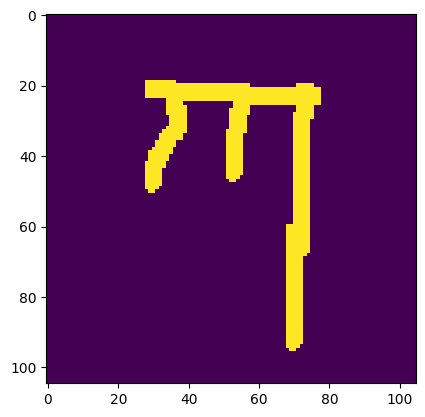

In [99]:
type(data_task1['unseen_images'])
data_task1['unseen_images'].keys()
data_task1['unseen_images']['Tibetan'][4,0,...]
plt.imshow(data_task1['unseen_images']['Tibetan'][4,0,...])

In [100]:
def val(test_data, model, alphabet, k=8):
  x_test_train, y_test_train, x_test_valid, y_test_valid, label_dict = process_test_data(test_data, alphabet)
  counts = [0 for _ in range(k)]
  count = 0

  train_outputs = [ ]
  model.eval()  # evaluation mode
  with torch.no_grad():


    for train_idx in range(len(x_test_train)):
      train_outputs.append(model(x_test_train[train_idx].unsqueeze(0)))
    for test_idx in range(len(x_test_valid)):
      # Check distance for query in relation to all other images in the known train set
      distances = []
      output2 = model(x_test_valid[test_idx].unsqueeze(0))
      for train_idx in range(len(x_test_train)):
        dist = (train_outputs[train_idx] - output2).pow(2).sum(1)
        distances.append(dist.item())

      value, index = topk.topk_standard(distances)
      for i in range(k):
        if (y_test_valid[test_idx] in index[:i+1]):
            counts[i] += 1
  return [counts, len(x_test_valid), [c/len(x_test_valid) for c in counts]]


def calculate_accuracy(test_data, model, k):
  result = []
  counts = [0 for _ in range(k)]
  total = 0
  alphabets = list(test_data['unseen_images'].keys())
  for alphabet in tqdm(alphabets):
    alphabet_result = val(test_data, model, alphabet, k)
    counts = [sum(x) for x in zip(counts, alphabet_result[0])]
    total += alphabet_result[1]
    # print(f"{[counts, total, [round(c/total, 2) for c in counts]]}")
  return [round(c/total, 2) for c in counts]


result = calculate_accuracy(data_task1, mined_embedding_net, 8)



100%|██████████| 20/20 [00:49<00:00,  2.48s/it]


In [214]:
topk.display(result)

top-1 = 0.13
top-2 = 0.2
top-3 = 0.24
top-4 = 0.29
top-5 = 0.33
top-6 = 0.36
top-7 = 0.4
top-8 = 0.42


To evaluate the model against a random guessing baseline, we can create a function that generates random predictions and calculates the top-k accuracy. Here's how you can do it:

In [102]:
def random_baseline(test_data, k_values=[1, 2, 3, 4, 5, 6, 7, 8]):
    alphabets = list(test_data['unseen_images'].keys())
    total = 0
    counts = {k: 0 for k in k_values}

    for alphabet in alphabets[::-1]:
        x_test_train, y_test_train, x_test_valid, y_test_valid, label_dict = process_test_data(test_data, alphabet)
        total += len(x_test_valid)

        for test_idx in range(len(x_test_valid)):
            # Generate random predictions
            random_predictions = torch.randint(0, len(x_test_train), (max(k_values),))
            for k in k_values:
                # Check if the true label is in the top-k random predictions
                if y_test_valid[test_idx] in random_predictions[:k]:
                    counts[k] += 1
    accuracies = []
    # Calculate top-k accuracy for each k
    #accuracies = {k: round(counts[k] / total, 2) for k in k_values}
    for k in k_values:
        accuracies.append(round(counts[k] / total, 2))
    #for k in k_values:
    #  print(round(counts[k]),total)
    return accuracies

random_baseline_result = random_baseline(data_task1)
print(random_baseline_result)
topk.display(random_baseline_result)

[0.03, 0.06, 0.09, 0.11, 0.14, 0.17, 0.19, 0.21]
top-1 = 0.03
top-2 = 0.06
top-3 = 0.09
top-4 = 0.11
top-5 = 0.14
top-6 = 0.17
top-7 = 0.19
top-8 = 0.21


100%|██████████| 20/20 [00:48<00:00,  2.43s/it]


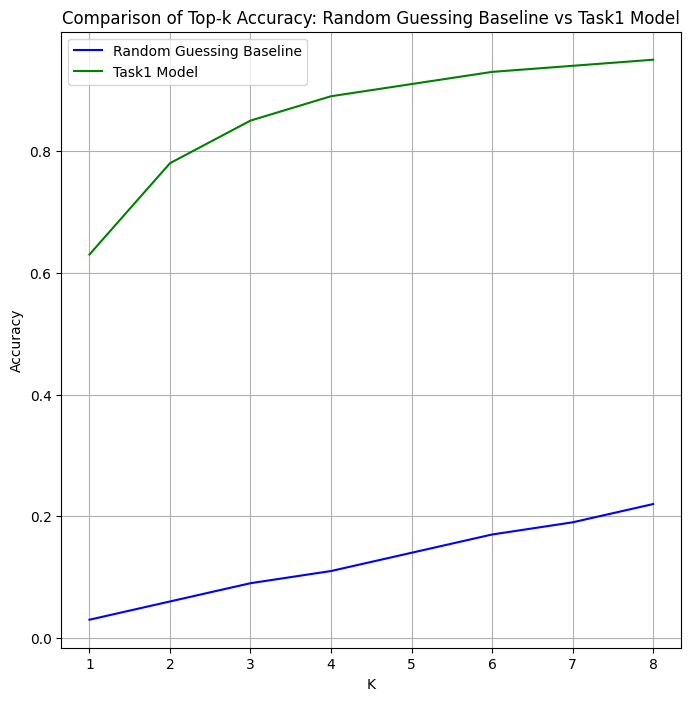

In [103]:
random_baseline_result = random_baseline(data_task1)
result = calculate_accuracy(data_task1, mined_embedding_net, 8)
k = [1,2,3,4,5,6,7,8]
#plt.plot(k,result)

# Generate some data for plotting
#x = np.linspace(0, 10, 100)
y1 = random_baseline_result
y2 = result

# Create a figure and a single axes
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the first line
ax.plot(k, y1, label='Random Guessing Baseline', color='blue')
ax.plot(k, y2, label='Task1 Model', color='green')


ax.set_title('Comparison of Top-k Accuracy: Random Guessing Baseline vs Task1 Model')
ax.set_xlabel('K')
ax.set_ylabel('Accuracy')
ax.legend()
ax.grid(True)
plt.show()

This function generates random predictions for each test sample and checks if the true label is within the top-k random predictions for each k in {1, 2, 4, 8}. The top-k accuracy is then calculated by dividing the number of correct predictions by the total number of test samples.

In [110]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def display_image(data, alphabet, character, image_id, ax, title=""):
    """
    Display a single image from the provided data.
    """
    ax.set_title(title)
    ax.axis('off')

def val_and_collect(test_data, model, alphabet, k=8):
    x_test_train, y_test_train, x_test_valid, y_test_valid, label_dict = process_test_data(test_data, alphabet)
    counts = [0 for _ in range(k)]
    correct_predictions = []
    incorrect_predictions = []

    train_outputs = []
    model.eval()  # evaluation mode
    with torch.no_grad():
        for train_idx in range(len(x_test_train)):
            train_outputs.append(model(x_test_train[train_idx].unsqueeze(0)))
        for test_idx in range(len(x_test_valid)):
            distances = []
            output2 = model(x_test_valid[test_idx].unsqueeze(0))
            for train_idx in range(len(x_test_train)):
                dist = (train_outputs[train_idx] - output2).pow(2).sum(1)
                distances.append(dist.item())

            value, index = torch.topk(torch.tensor(distances), k, largest=False)

            true_label = y_test_valid[test_idx]
            predicted_indices = index.tolist()

            if true_label in predicted_indices[:k]:
                correct_predictions.append((true_label, predicted_indices, test_idx))
            else:
                incorrect_predictions.append((true_label, predicted_indices, test_idx))

            for i in range(k):
                if (true_label in predicted_indices[:i+1]):
                    counts[i] += 1

    return counts, len(x_test_valid), [c/len(x_test_valid) for c in counts], correct_predictions, incorrect_predictions

def evaluate_and_display_results(test_data, model, k):
    counts = [0 for _ in range(k)]
    total = 0
    correct_predictions = []
    incorrect_predictions = []
    alphabets = list(test_data['unseen_images'].keys())

    for alphabet in alphabets[::-1]:
        alphabet_counts, alphabet_total, _, correct, incorrect = val_and_collect(test_data, model, alphabet, k)
        counts = [sum(x) for x in zip(counts, alphabet_counts)]
        total += alphabet_total
        correct_predictions.extend(correct)
        incorrect_predictions.extend(incorrect)

    print(f"Accuracy for top-{k}: {round(counts[k-1] / total, 2)}")

    print("Correct")
    for idx, (true_label, predicted_indices, test_idx) in enumerate(correct_predictions[:5]):
         alphabet, character, image_id = true_label // 100, true_label % 100, test_idx
         print(f"True: {true_label}\nPred: {predicted_indices}")

    print('Incorrect')
    for idx, (true_label, predicted_indices, test_idx) in enumerate(incorrect_predictions[:5]):
         alphabet, character, image_id = true_label // 100, true_label % 100, test_idx
         print(f"True Lable: {true_label}\n Predicted: {predicted_indices}")

In [105]:
evaluate_and_display_results(data_task1, mined_embedding_net, 8)

Accuracy for top-8: 0.95
Correct
True: 0
Pred: [0, 12, 7, 10, 4, 16, 8, 13]
True: 0
Pred: [12, 0, 1, 16, 25, 8, 14, 10]
True: 0
Pred: [12, 0, 1, 25, 11, 17, 14, 16]
True: 0
Pred: [12, 0, 1, 25, 11, 10, 16, 14]
True: 0
Pred: [0, 7, 4, 12, 10, 24, 13, 8]
Incorrect
True Lable: 16
 Predicted: [2, 14, 15, 21, 5, 25, 3, 12]
True Lable: 16
 Predicted: [11, 19, 25, 12, 5, 18, 15, 20]
True Lable: 16
 Predicted: [5, 11, 10, 12, 22, 19, 15, 20]
True Lable: 16
 Predicted: [14, 15, 5, 25, 12, 19, 2, 20]
True Lable: 18
 Predicted: [22, 15, 14, 5, 12, 25, 23, 11]


Accuracy for top-8: 0.95


IndexError: index 410 is out of bounds for dimension 0 with size 380

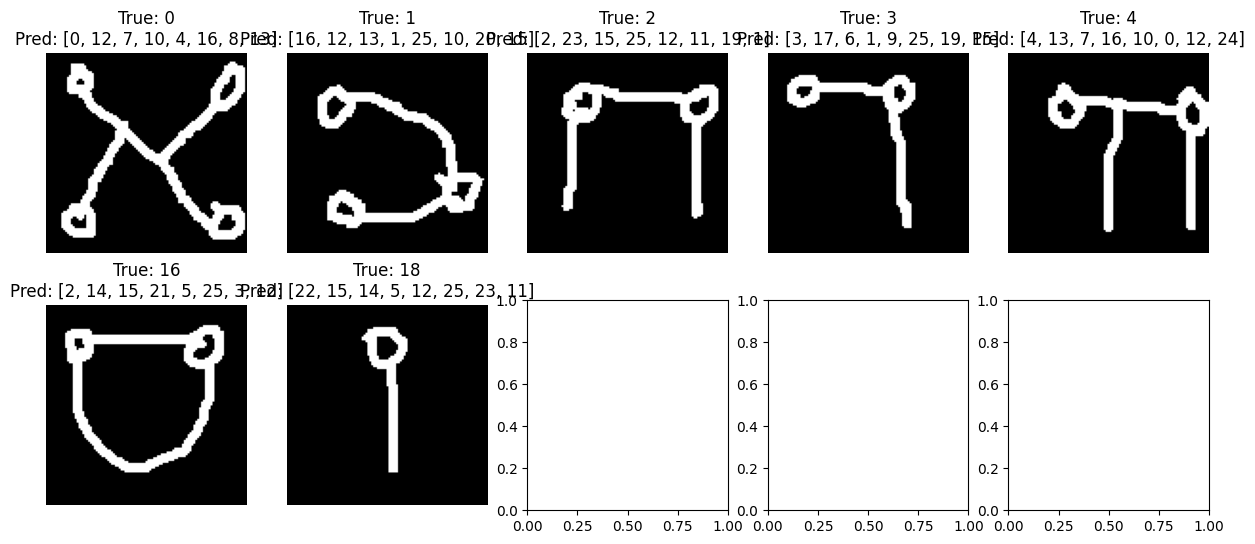

In [109]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def display_image(data, alphabet, character, image_id, ax, title=""):
    """
    Display a single image from the provided data.
    """
    image = data[alphabet][image_id,0,...]
    ax.imshow(np.squeeze(image), cmap='gray')
    ax.set_title(title)
    ax.axis('off')

def val_and_collect(test_data, model, alphabet, k=8):
    x_test_train, y_test_train, x_test_valid, y_test_valid, label_dict = process_test_data(test_data, alphabet)
    counts = [0 for _ in range(k)]
    correct_predictions = []
    incorrect_predictions = []

    train_outputs = []
    model.eval()  # evaluation mode
    with torch.no_grad():
        for train_idx in range(len(x_test_train)):
            train_outputs.append(model(x_test_train[train_idx].unsqueeze(0)))
        lables = []
        lables_in = []
        for test_idx in range(len(x_test_valid)):
            distances = []
            output2 = model(x_test_valid[test_idx].unsqueeze(0))
            for train_idx in range(len(x_test_train)):
                dist = (train_outputs[train_idx] - output2).pow(2).sum(1)
                distances.append(dist.item())

            value, index = torch.topk(torch.tensor(distances), k, largest=False)

            true_label = y_test_valid[test_idx]
            predicted_indices = index.tolist()

            if true_label in predicted_indices[:k] and true_label not in lables:
                correct_predictions.append((true_label, predicted_indices, test_idx))
                lables.append(true_label)
            elif true_label not in predicted_indices[:k] and true_label not in lables_in:
                incorrect_predictions.append((true_label, predicted_indices, test_idx))
                lables_in.append(true_label)
            for i in range(k):
                if (true_label in predicted_indices[:i+1]):
                    counts[i] += 1

    return counts, len(x_test_valid), [c/len(x_test_valid) for c in counts], correct_predictions, incorrect_predictions

def evaluate_and_display_results(test_data, model, k):
    counts = [0 for _ in range(k)]
    total = 0
    correct_predictions = []
    incorrect_predictions = []
    alphabets = list(test_data['unseen_images'].keys())

    for alphabet in alphabets[::-1]:
        alphabet_counts, alphabet_total, _, correct, incorrect = val_and_collect(test_data, model, alphabet, k)
        counts = [sum(x) for x in zip(counts, alphabet_counts)]
        total += alphabet_total
        correct_predictions.extend(correct)
        incorrect_predictions.extend(incorrect)

    print(f"Accuracy for top-{k}: {round(counts[k-1] / total, 2)}")

    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    for idx, (true_label, predicted_indices, test_idx) in enumerate(correct_predictions[:5]):
         display_image(test_data['unseen_images'], alphabet, character, test_idx, axs[0, idx], f"True: {true_label}\nPred: {predicted_indices}")
    for idx, (true_label, predicted_indices, test_idx) in enumerate(incorrect_predictions[:5]):
         display_image(test_data['unseen_images'], alphabet, character, test_idx, axs[1, idx], f"True: {true_label}\nPred: {predicted_indices}")

    axs[0, 0].set_ylabel('Correct', fontsize=12)
    axs[1, 0].set_ylabel('Incorrect', fontsize=12)

    plt.tight_layout()
    plt.show()

evaluate_and_display_results(data_task1, mined_embedding_net, 8)

# Task 2: rotation problem

In [115]:
data_task2 = load_data(file_path + 'test_data_task2.pkl')

In [116]:
data_task2.keys()

dict_keys(['annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels'])

In [ ]:
# solution and evaluation of task 2:

In [117]:
rotater = T.RandomRotation(degrees=(-180, 180))
transform_task2 = T.Compose([rotater, resize])
x_train, y_train, info, info2 = process_data(train_data, transform_task2)
train_batch_sampler_task2 = BalancedBatchSampler(y_train, n_classes=20, n_samples=20)
triplets_train_loader_task2 = torch.utils.data.DataLoader(TensorDataset( torch.stack(x_train), torch.stack([torch.tensor(x) for x in y_train]) ), batch_sampler=train_batch_sampler_task2)

In [118]:
import copy
mined_embedding_net_task2 = copy.deepcopy(mined_embedding_net) # Copy model, since it already performed good on non-rotated images
mined_model_task2 = mined_embedding_net_task2.to(device)
margin=1
criterion = TripletLoss(margin, Informative_Negative_TripletSelector(margin))
optimizer = torch.optim.SGD(mined_model.parameters(), lr=0.1, momentum=0.9)
trainer = Trainer(model=mined_model_task2,device=device,criterion=criterion,optimizer=optimizer,training_DataLoader=triplets_train_loader_task2, epochs=10)
trainer.run_trainer() # train model again with 10 more epochs to account for rotated images

 10%|█         | 1/10 [00:46<06:58, 46.49s/it]

EPOCH: 01/10
 LOSS: 4.8668 

 20%|██        | 2/10 [01:32<06:09, 46.23s/it]

EPOCH: 02/10
 LOSS: 4.9819 

 30%|███       | 3/10 [02:15<05:14, 44.91s/it]

EPOCH: 03/10
 LOSS: 5.0517 

 40%|████      | 4/10 [03:00<04:29, 44.92s/it]

EPOCH: 04/10
 LOSS: 5.0150 

 50%|█████     | 5/10 [03:44<03:42, 44.42s/it]

EPOCH: 05/10
 LOSS: 4.8557 

 60%|██████    | 6/10 [04:29<02:58, 44.58s/it]

EPOCH: 06/10
 LOSS: 4.9129 

 70%|███████   | 7/10 [05:13<02:13, 44.52s/it]

EPOCH: 07/10
 LOSS: 5.0076 

 80%|████████  | 8/10 [05:57<01:28, 44.34s/it]

EPOCH: 08/10
 LOSS: 5.0197 

 90%|█████████ | 9/10 [06:42<00:44, 44.64s/it]

EPOCH: 09/10
 LOSS: 4.9351 

100%|██████████| 10/10 [07:27<00:00, 44.70s/it]

EPOCH: 10/10
 LOSS: 4.9678 

In [122]:
print(f"result test data 2 on model task2")
result_data2_model2 = calculate_accuracy(data_task2, mined_embedding_net_task2, 8)
print(f"result test data 2 on model task 1")
result_data2_model1 = calculate_accuracy(data_task2, mined_embedding_net, 8)

result test data 2 on model task2


100%|██████████| 20/20 [00:46<00:00,  2.34s/it]


result test data 2 on model task 1


100%|██████████| 20/20 [00:46<00:00,  2.35s/it]


In [124]:
print(f"result test data 2 on model 2")
topk.display(result_data2_model2)
print(f"result test data 2 on model 1")
topk.display(result_data2_model1)

result test data 2 on model 2
top-1 = 0.15
top-2 = 0.22
top-3 = 0.27
top-4 = 0.31
top-5 = 0.35
top-6 = 0.38
top-7 = 0.42
top-8 = 0.45
result test data 2 on model 1
top-1 = 0.13
top-2 = 0.2
top-3 = 0.24
top-4 = 0.29
top-5 = 0.33
top-6 = 0.36
top-7 = 0.4
top-8 = 0.42


We can see that model 2 performs better than model 1, when predicting images that have been possibly rotated

(1368,)
(1368, 2)


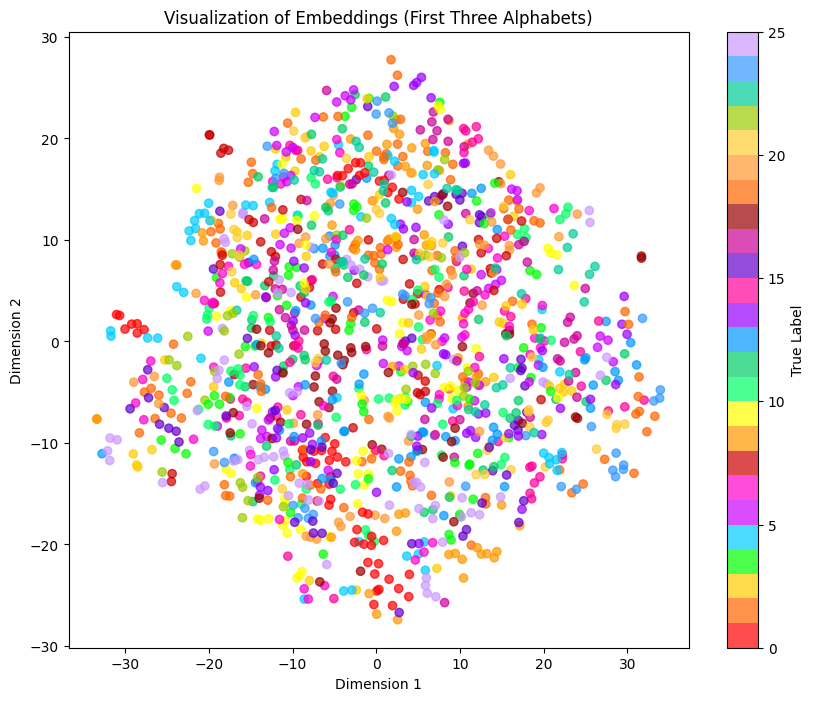

In [127]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def val(test_data, model, alphabet):
    x_test_train, y_test_train, x_test_valid, y_test_valid, label_dict = process_test_data(test_data, alphabet)
    train_outputs = []

    model.eval()  # evaluation mode
    with torch.no_grad():
        # Compute embeddings for validation set
        for valid_idx in range(len(x_test_valid)):
            output = model(x_test_valid[valid_idx].unsqueeze(0))
            train_outputs.append(output)

    train_outputs = torch.cat(train_outputs, dim=0).cpu().numpy()
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(train_outputs)

    return reduced_embeddings, y_test_valid

def visualise_embeddings(test_data, model):
    reduced_embeddings_all = []
    y_test_valid_all = []

    alphabets = list(test_data['unseen_images'].keys())[:3]  # Limit to the first three alphabets

    for alphabet in alphabets:
        reduced_embeddings, y_test_valid = val(test_data, model, alphabet)
        reduced_embeddings_all.append(reduced_embeddings)
        y_test_valid_all.append(y_test_valid)

    reduced_embeddings_all = np.concatenate(reduced_embeddings_all)
    y_test_valid_all = np.concatenate(y_test_valid_all)
    #print(y_test_valid_all)
    print(y_test_valid_all.shape)
    print(reduced_embeddings_all.shape)

    aggressive_colors = [
    "#ff0000", "#ff6600", "#ffcc00", "#00ff00", "#00ccff",
    "#cc00ff", "#ff00cc", "#cc0000", "#ff9900", "#ffff00",
    "#00ff66", "#00cc66", "#0099ff", "#9900ff", "#ff0099",
    "#6600cc", "#cc0099", "#990000", "#ff6600", "#ff9933",
    "#ffcc33", "#99cc00", "#00cc99", "#3399ff", "#cc99ff"
    ]

    # Create a custom colormap
    #custom_cmap = "tab10"
    custom_cmap = ListedColormap(aggressive_colors)

    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_embeddings_all[:, 0], reduced_embeddings_all[:, 1], c=y_test_valid_all, cmap=custom_cmap, alpha=0.7)
    plt.title('Visualization of Embeddings (First Three Alphabets)')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.colorbar(label='True Label')
    plt.show()

# Run the accuracy calculation and get successful and failure cases
visualise_embeddings(data_task2, mined_embedding_net_task2)

# Task 3: Domain knowledge injection

In [128]:
data_task3 = load_data(file_path + 'test_data_task3.pkl')
print(data_task3.keys())

dict_keys(['unseen_images_labels', 'annotated_images_labels', 'unseen_images', 'annotated_images', 'unseen_images_preceding_types', 'character_to_type_mapping', 'type_following_probs'])


In [138]:

def val_task3(test_data, model, alphabet, k=8, method=None):
  character_to_type_mapping_alphabet = test_data["character_to_type_mapping"][alphabet]
  preceding_character_types_alphabet = test_data["unseen_images_preceding_types"][alphabet]
  type_following_probs_alphabet = test_data["type_following_probs"][alphabet]
  x_test_train, y_test_train, x_test_valid, y_test_valid, label_dict = process_test_data(test_data, alphabet)

  counts = [0 for _ in range(k)]
  count = 0

  train_outputs = [ ]
  # dataloader_validation = DataLoader(dataset=dataset_valid,batch_size=2,shuffle=False)

  model.eval()  # evaluation mode
  with torch.no_grad():


    for train_idx in range(len(x_test_train)):
      train_outputs.append(model(x_test_train[train_idx].unsqueeze(0).to(device)))
    for test_idx in range(len(x_test_valid)):
      # Check distance for query in relation to all other images in the known train set
      distances = []
      probs = []
      output2 = model(x_test_valid[test_idx].unsqueeze(0).to(device))
      actual_preceding_type = preceding_character_types_alphabet[test_idx]
      for train_idx in range(len(x_test_train)):
        hypothetical_type = character_to_type_mapping_alphabet[label_dict[y_test_train[train_idx]]];
        prob = type_following_probs_alphabet[actual_preceding_type][hypothetical_type]
        probs.append(prob)
        # print(f"preceding {actual_preceding_type}, hypotethical {hypothetical_type}, prob {prob}")
        dist = (train_outputs[train_idx] - output2).pow(2).sum(1)# * ((1/ prob)/2)
        distances.append(dist.item())

      # print("distances", distances)
      # print("distances soft", softmax(np.array(distances)))
      # print("probs", probs)
      # value, index = torch.topk(torch.tensor(distances), k, largest=False)
    #   value, index = topk(k, distances, method=method, probs=probs)
      value, index = topk.topk(distances, method=method, probs=probs)
      # print(f"ytrue: {y_test_valid[test_idx]} pred: {index}")
      for i in range(k):
        if (y_test_valid[test_idx] in index[:i+1]):
            counts[i] += 1
  return [counts, len(x_test_valid), [c/len(x_test_valid) for c in counts]]

def calculate_accuracy_task3(test_data, model, k, method=None):
  result = []
  counts = [0 for _ in range(k)]
  total = 0
  alphabets = list(test_data['unseen_images'].keys())
  for alphabet in tqdm(alphabets):
    alphabet_result = val_task3(test_data, model, alphabet, k, method=method)
    counts = [sum(x) for x in zip(counts, alphabet_result[0])]
    total += alphabet_result[1]
    # print(f"{[counts, total, [round(c/total, 2) for c in counts]]}")
  return [round(c/total, 2) for c in counts]


In [173]:
methods, names = topk.get_methods()
results = []
for method in methods:
    results.append(calculate_accuracy_task3(data_task3, mined_embedding_net, 8, method=method))

100%|██████████| 20/20 [00:48<00:00,  2.44s/it]


In [174]:
for i in range(len(results)):
    print(f"{names[i], results[i]}")

('standard', [0.63, 0.78, 0.85, 0.89, 0.91, 0.93, 0.94, 0.95])
('2compare', [0.59, 0.76, 0.84, 0.88, 0.91, 0.93, 0.94, 0.95])
('late prob swap 2', [0.6, 0.76, 0.83, 0.87, 0.9, 0.92, 0.94, 0.95])


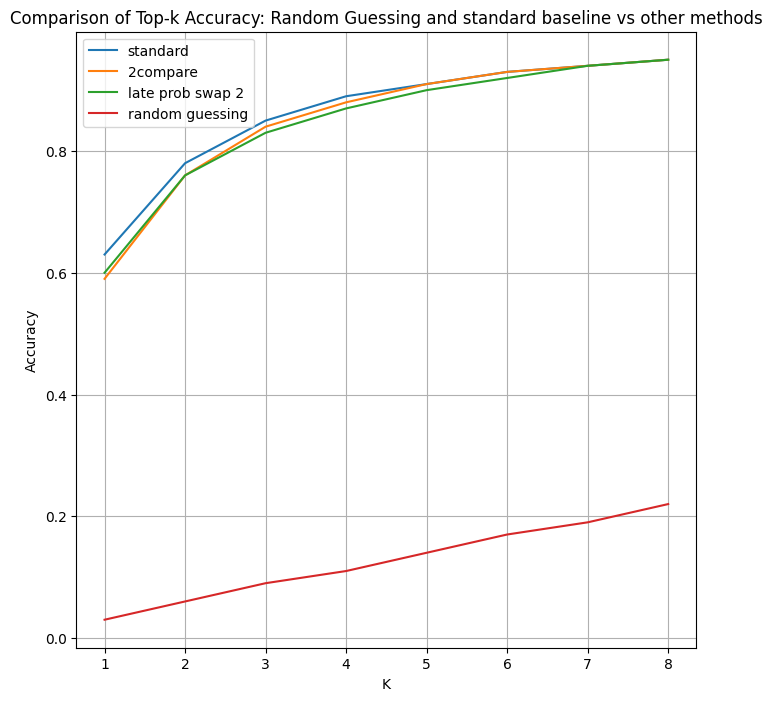

In [175]:
results.append(random_baseline_result)
names.append("random guessing")

k=[1,2,3,4,5,6,7,8]

y1 = random_baseline_result
y2 = result

# Create a figure and a single axes
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the first line
for i in range(len(results[:len(methods)+1])):
    ax.plot(k, results[i], label=names[i])
ax.set_title('Comparison of Top-k Accuracy: Random Guessing and standard baseline vs other methods')
ax.set_xlabel('K')
ax.set_ylabel('Accuracy')
ax.legend()
ax.grid(True)
plt.show()

Extra experiment - probability comparison

In [205]:
def val_task3(test_data, model, alphabet, k=8, method=None):
  character_to_type_mapping_alphabet = test_data["character_to_type_mapping"][alphabet]
  preceding_character_types_alphabet = test_data["unseen_images_preceding_types"][alphabet]
  type_following_probs_alphabet = test_data["type_following_probs"][alphabet]
  x_test_train, y_test_train, x_test_valid, y_test_valid, label_dict = process_test_data(test_data, alphabet)

  counts = [0 for _ in range(k)]
  count = 0
  total_probs = [0 for _ in range(k)]

  train_outputs = [ ]
  # dataloader_validation = DataLoader(dataset=dataset_valid,batch_size=2,shuffle=False)

  model.eval()  # evaluation mode
  with torch.no_grad():


    for train_idx in range(len(x_test_train)):
      train_outputs.append(model(x_test_train[train_idx].unsqueeze(0).to(device)))
    for test_idx in range(len(x_test_valid[:1])):
      # Check distance for query in relation to all other images in the known train set
      distances = []
      probs = []
      output2 = model(x_test_valid[test_idx].unsqueeze(0).to(device))
      actual_preceding_type = preceding_character_types_alphabet[test_idx]
      for train_idx in range(len(x_test_train)):
        hypothetical_type = character_to_type_mapping_alphabet[label_dict[y_test_train[train_idx]]];
        prob = type_following_probs_alphabet[actual_preceding_type][hypothetical_type]
        probs.append(prob)
        # print(f"preceding {actual_preceding_type}, hypotethical {hypothetical_type}, prob {prob}")
        dist = (train_outputs[train_idx] - output2).pow(2).sum(1)# * ((1/ prob)/2)
        distances.append(dist.item())
      value, index = topk.topk(distances, method=method, probs=probs)
      p = topk.get_probs(index, probs)
      # print(f"ytrue: {y_test_valid[test_idx]} pred: {index}")
      total_probs = [sum(x) for x in zip(total_probs, p)]
      print(total_probs)
      for i in range(k):
        if (y_test_valid[test_idx] in index[:i+1]):
            counts[i] += 1
  return [counts, len(x_test_valid), [c/len(x_test_valid) for c in counts], total_probs]

def calculate_accuracy_task3(test_data, model, k, method=None):
  result = []
  counts = [0 for _ in range(k)]
  total = 0
  probs = [0 for _ in range(k)]
  alphabets = list(test_data['unseen_images'].keys())
  for alphabet in tqdm(alphabets[:1]):
    print(probs)
    alphabet_result = val_task3(test_data, model, alphabet, k, method=method)
    counts = [sum(x) for x in zip(counts, alphabet_result[0])]
    total += alphabet_result[1]
    probs = [sum(x) for x in zip(probs, alphabet_result[-1])]

    # print(f"{[counts, total, [round(c/total, 2) for c in counts]]}")
  return probs

In [206]:
methods, names = topk.get_methods()
results = []
for method in [0,5]:
    results.append(calculate_accuracy_task3(data_task3, mined_embedding_net, 8, method=method))

100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


[0, 0, 0, 0, 0, 0, 0, 0]
[0.5409836065573771, 0.45901639344262296, 0.45901639344262296, 0.45901639344262296, 0.5409836065573771, 0.45901639344262296, 0.45901639344262296, 0.5409836065573771]


  0%|          | 0/1 [00:00<?, ?it/s]

[0, 0, 0, 0, 0, 0, 0, 0]


100%|██████████| 1/1 [00:00<00:00,  6.11it/s]

[0.5409836065573771, 0.45901639344262296, 0.45901639344262296, 0.5409836065573771, 0.45901639344262296, 0.45901639344262296, 0.5409836065573771, 0.45901639344262296]


[[1.0, 1.0, 0.9180327868852459, 0.9180327868852459, 1.0, 1.0, 1.0, 1.0], [1.0819672131147542, 0.9180327868852459, 0.9180327868852459, 1.0, 1.0, 1.0, 1.0, 0.9180327868852459]]


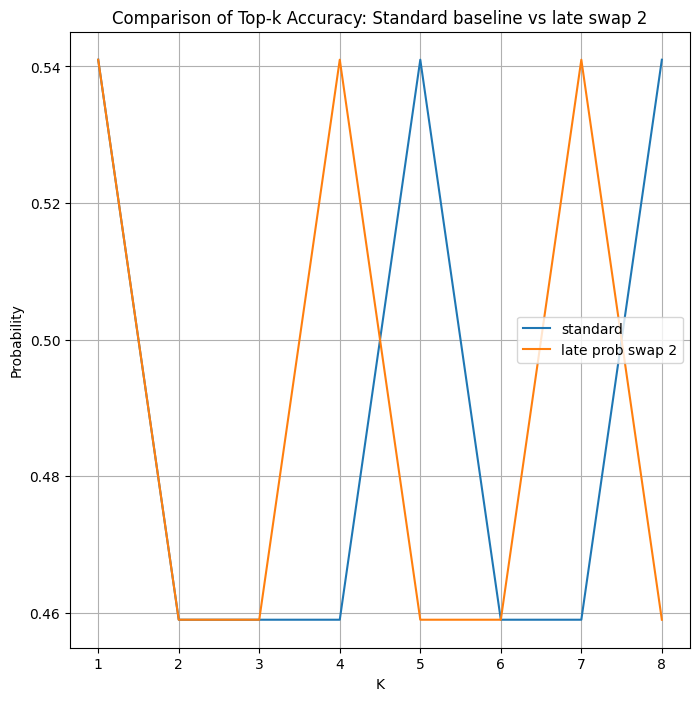

In [210]:
k=[1,2,3,4,5,6,7,8]

y1 = random_baseline_result
y2 = result

# Create a figure and a single axes
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the first line
# for i in range(len(results[:len(methods)+1])):
ax.plot(k, results[0], label="standard")
ax.plot(k, results[1], label="late prob swap 2")
ax.set_title('Comparison of Top-k Accuracy: Standard baseline vs late swap 2')
ax.set_xlabel('K')
ax.set_ylabel('Probability')
ax.legend()
ax.grid(True)
plt.show()

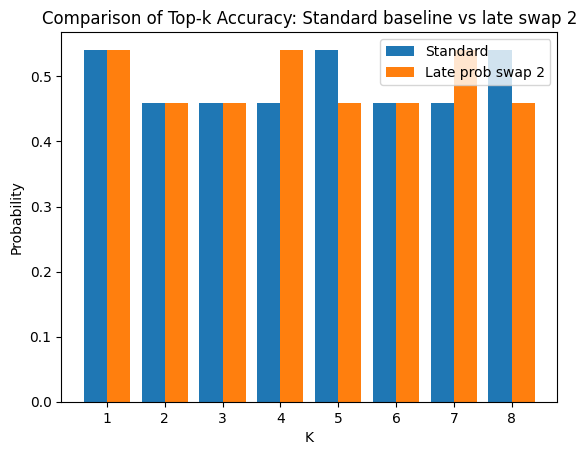

In [213]:

import numpy as np  
import matplotlib.pyplot as plt  

X = [1,2,3,4,5,6,7,8]
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis - 0.2, results[0], 0.4, label = 'Standard') 
plt.bar(X_axis + 0.2, results[1], 0.4, label = 'Late prob swap 2') 
  
plt.xticks(X_axis, X) 
plt.xlabel("K") 
plt.ylabel("Probability") 
plt.title("Comparison of Top-k Accuracy: Standard baseline vs late swap 2") 
plt.legend() 
plt.show() 